# Imports

Brittany C. Haas and Melissa A. Hardy's jupyter notebook for automated collection of molecular descriptors and post-processing (i.e., Boltzmann average, min/max values, etc.).

**NOTE: Make sure to use the get_properties_environment file to set your conda environment.**

In [1]:
import os,re,sys,pickle,datetime,time,random,itertools,glob
from itertools import permutations
import warnings
warnings.filterwarnings("ignore")
import numpy as np
np.set_printoptions(threshold=sys.maxsize) #print out full arrays
import openpyxl
from openpyxl import load_workbook
import pandas as pd
from pandas import ExcelWriter
import xlsxwriter

import math
randomstate = 42

from rdkit import Chem

import goodvibes.GoodVibes as gv
import goodvibes.thermo as thermo
import goodvibes.io as io
import goodvibes.pes as pes
from morfeus import ConeAngle
from morfeus import Sterimol
import get_properties_functions_for_WI as gp

In [2]:
npa_pattern = re.compile("Summary of Natural Population Analysis:")
nbo_os_pattern = re.compile("beta spin orbitals")
nborbs_pattern = "NATURAL BOND ORBITALS (Summary):" #"Natural Bond Orbitals (Summary)"
nborbs2_pattern = re.compile("NATURAL BOND ORBITALS (Summary):")

def get_one_lp_energy(dataframe, a_list): #a function to get the NB orbitals for all atoms (a_list, form ["C1", "C4", "O2"]) in a dataframe that contains file name and atom number
    nborbs_dataframe = pd.DataFrame(columns=[]) #define an empty df to place results in
                
    for index, row in dataframe.iterrows(): #iterate over the dataframe 
        try: #try to get the data
            atomnum_list = [] 
            for atom in a_list: 
                atomnum = row[str(atom)] #the atom number (i.e. 16) to add to the list is the df entry of this row for the labeled atom (i.e. "C1")
                atomnum_list.append(str(atomnum)) #append that to atomnum_list to make a list of the form [16, 17, 29]
            
            log_file = row['log_name'] #read file name from df
            filecont, error = gp.get_filecont(log_file) #read the contents of the log file
            if error != "":
                print(error)
                row_i = {}
                for a in range(0, len(a_list)):
                    entry = {'NBO_charge_'+str(a_list[a]): "no data"}
                    row_i.update(entry)
                nborbs_dataframe = nborbs_dataframe.append(row_i, ignore_index=True)
                continue
        
            nborbsstart = 0
            #this section finds the line (nborbsstart) where the nbo data is located
            for i in range(len(filecont)-1,0,-1):
                if nborbs_pattern in filecont[i]:#search the file content for the phrase which indicates the start of the NB orbitals section 
                    nborbsstart = i   
            if nborbsstart == 0: 
                error = "****no Natural Bond Orbitals found in: " + str(row['log_name']) + ".log"
                print(error)
                row_i = {}
                for a in range(0, len(a_list)):
                    entry = {'NBO_charge_'+str(a_list[a]): "no data"}
                    row_i.update(entry)
                nborbs_dataframe = nborbs_dataframe.append(row_i, ignore_index=True)
                continue
           
            for atom in a_list: 
                k = 0
                atom_num = row[str(atom)]
                for j in range(nborbsstart,len(filecont)):
                    if str(atom_num) in " ".join(re.findall("([A-Z][a-z]? *[0-9]+)",filecont[j])).split() and ("LP" in filecont[j]):
                        orbital_section = re.search("[0-9]+\.[A-Z\*(0-9 ]+\)",filecont[j]).group(0) #type of MO
                        orbital = orbital_section.split(". ")
                        orb = orbital[1]
                        des = orb.split(" ")
                        orb_type = des[0]
                        occ_energy = [x for x in re.findall(r"[-+]?\d*\.\d+",filecont[j])]
                        occ = occ_energy[0]
                        energy = occ_energy[1]
                        k += 1
                        #print(k)
                if k == 0: 
                    error = "****no LPs for atom " + str(atom)+ " in: " + str(row['log_name']) + ".log"
                    print(error)
                    row_i = {}
                    for atom in a_list:
                        entry = {'NBO_LP_occupancy_' + str(atom): "no data", 'NBO_LP_energy_' + str(atom): "no data"}
                        row_i.update(entry)
                    nborbs_dataframe = nborbs_dataframe.append(row_i, ignore_index=True)
                    pass
                if k == 2: 
                    error = "****more than one LP for atom " + str(atom)+ " in: " + str(row['log_name']) + ".log"
                    print(error)
                    row_i = {}
                    for atom in a_list:
                        entry = {'NBO_LP_occupancy_' + str(atom): "no data", 'NBO_LP_energy_' + str(atom): "no data"}
                        row_i.update(entry)
                    nborbs_dataframe = nborbs_dataframe.append(row_i, ignore_index=True)
                    continue
            
            #this adds the data from the nboout into the new property df
            row_i = {}
            for atom in a_list:
                entry = {'NBO_LP_occupancy_' + str(atom): occ, 'NBO_LP_energy_' + str(atom): energy}
                row_i.update(entry)
            #print(row_i)
            print(row_i)
            nborbs_dataframe = nborbs_dataframe.append(row_i, ignore_index=True)
        except:
            print('****Unable to acquire NBO orbitals for:', row['log_name'], ".log")
            row_i = {}
            for a in range(0, len(a_list)):
                entry = {'NBO_charge_'+str(a_list[a]): "no data"}
                row_i.update(entry)
            nborbs_dataframe = nborbs_dataframe.append(row_i, ignore_index=True)
    print("NBOrbs function has completed for", a_list)
    return(pd.concat([dataframe, nborbs_dataframe], axis = 1))

# Atom Inputs Dataframe

Portions of this section were adapted from code written Jordan P. Liles.

## Generate dataframe with atom numbers

### Use command line to prepare files

To create files: navigate to folder that contains all the log files you wish to analyze.

    module load openbabel
    obabel *.log -osdf -m
    ls *.log > log_ids.txt
    cat *.sdf >> molecules.sdf

You will use the log_ids.txt and molecules.sdf files in the rest of 2.1.

### !change to the code

In [3]:
# if under linux, execute the "module load openbabel" in the terminal
if sys.platform == "linux" or sys.platform == "linux2":
    !module load openbabel

!obabel *.log -osdf -m

60 molecules converted
60 files output. The first is pyrd10_conf-1.sdf


### You must name the same type of molecule in a unique common prefix (need to be all character) to use the following cell
##### for example pyridine all in pyrd + digit + whatever
##### for example pyrimidine all in pyrmd + digit + whatever

In [4]:
# list all *.log files in the directory, pipe those with a common prefix to a file name log_ids_prefix.txt

# we will first grep all the prefix, use regular expression to match all non-digit characters from the start of the filename
# the key will be the prefix, and the value will be a list of all the files with that prefix
log_prefix = {}
log_file_list = glob.glob("*.log")
for file in log_file_list:
    key = re.match("([a-zA-Z]+)", file).group(0)
    if key in log_prefix:
        log_prefix[key].append(file)
    else:
        log_prefix[key] = [file]

for key, value in log_prefix.items():
    print(f'"{key}": {value},')

"pyrd": ['pyrd10_conf-1.log', 'pyrd10_conf-10.log', 'pyrd10_conf-11.log', 'pyrd10_conf-12.log', 'pyrd10_conf-13.log', 'pyrd10_conf-2.log', 'pyrd10_conf-3.log', 'pyrd10_conf-4.log', 'pyrd10_conf-5.log', 'pyrd10_conf-6.log', 'pyrd10_conf-7.log', 'pyrd10_conf-8.log', 'pyrd10_conf-9.log', 'pyrd11_conf-1.log', 'pyrd11_conf-2.log', 'pyrd12_conf-1.log', 'pyrd13_conf-1.log', 'pyrd1_conf-1.log', 'pyrd2_conf-1.log', 'pyrd3_conf-1.log', 'pyrd4_conf-1.log', 'pyrd4_conf-2.log', 'pyrd4_conf-3.log', 'pyrd4_conf-4.log', 'pyrd4_conf-5.log', 'pyrd4_conf-6.log', 'pyrd4_conf-7.log', 'pyrd4_conf-8.log', 'pyrd5_conf-1.log', 'pyrd6_conf-1.log', 'pyrd6_conf-2.log', 'pyrd6_conf-3.log', 'pyrd7_conf-1.log', 'pyrd7_conf-2.log', 'pyrd8_conf-1.log', 'pyrd8_conf-2.log', 'pyrd9_conf-1.log'],
"pyrdz": ['pyrdz1_conf-1.log', 'pyrdz1_conf-2.log', 'pyrdz1_conf-3.log', 'pyrdz1_conf-4.log'],
"pyrmd": ['pyrmd1_conf-1.log', 'pyrmd1_conf-2.log', 'pyrmd1_conf-3.log', 'pyrmd1_conf-4.log', 'pyrmd2_conf-1.log', 'pyrmd2_conf-2.log'

In [5]:
# generate log_ids_prefix.txt for each prefix
output_file_prefix = "log_ids_"
for key in log_prefix:
    with open(output_file_prefix + key + ".txt", "w") as f:
        for item in log_prefix[key]:
            f.write("%s\n" % item)
            print(f"wrote {item} to {output_file_prefix + key}.txt")

wrote pyrd10_conf-1.log to log_ids_pyrd.txt
wrote pyrd10_conf-10.log to log_ids_pyrd.txt
wrote pyrd10_conf-11.log to log_ids_pyrd.txt
wrote pyrd10_conf-12.log to log_ids_pyrd.txt
wrote pyrd10_conf-13.log to log_ids_pyrd.txt
wrote pyrd10_conf-2.log to log_ids_pyrd.txt
wrote pyrd10_conf-3.log to log_ids_pyrd.txt
wrote pyrd10_conf-4.log to log_ids_pyrd.txt
wrote pyrd10_conf-5.log to log_ids_pyrd.txt
wrote pyrd10_conf-6.log to log_ids_pyrd.txt
wrote pyrd10_conf-7.log to log_ids_pyrd.txt
wrote pyrd10_conf-8.log to log_ids_pyrd.txt
wrote pyrd10_conf-9.log to log_ids_pyrd.txt
wrote pyrd11_conf-1.log to log_ids_pyrd.txt
wrote pyrd11_conf-2.log to log_ids_pyrd.txt
wrote pyrd12_conf-1.log to log_ids_pyrd.txt
wrote pyrd13_conf-1.log to log_ids_pyrd.txt
wrote pyrd1_conf-1.log to log_ids_pyrd.txt
wrote pyrd2_conf-1.log to log_ids_pyrd.txt
wrote pyrd3_conf-1.log to log_ids_pyrd.txt
wrote pyrd4_conf-1.log to log_ids_pyrd.txt
wrote pyrd4_conf-2.log to log_ids_pyrd.txt
wrote pyrd4_conf-3.log to log_ids

In [6]:
# list all *.sdf files in the directory, pipe those with a common prefix to a file name log_ids_prefix.txt

# we will first grep all the prefix, use regular expression to match all non-digit characters from the start of the filename
# the key will be the prefix, and the value will be a list of all the files with that prefix
sdf_prefix = {}
log_file_list = glob.glob("*.sdf")
for file in log_file_list:
    key = re.match("([a-zA-Z]+)", file).group(0)
    # check this against the key of prefix dictionary, if not present, skip
    if key in log_prefix:
        if key in sdf_prefix:
            sdf_prefix[key].append(file)
        else:
            sdf_prefix[key] = [file]

for key, value in sdf_prefix.items():
    print(f'"{key}": {value},')

"pyrd": ['pyrd10_conf-1.sdf', 'pyrd10_conf-10.sdf', 'pyrd10_conf-11.sdf', 'pyrd10_conf-12.sdf', 'pyrd10_conf-13.sdf', 'pyrd10_conf-2.sdf', 'pyrd10_conf-3.sdf', 'pyrd10_conf-4.sdf', 'pyrd10_conf-5.sdf', 'pyrd10_conf-6.sdf', 'pyrd10_conf-7.sdf', 'pyrd10_conf-8.sdf', 'pyrd10_conf-9.sdf', 'pyrd11_conf-1.sdf', 'pyrd11_conf-2.sdf', 'pyrd12_conf-1.sdf', 'pyrd13_conf-1.sdf', 'pyrd1_conf-1.sdf', 'pyrd2_conf-1.sdf', 'pyrd3_conf-1.sdf', 'pyrd4_conf-1.sdf', 'pyrd4_conf-2.sdf', 'pyrd4_conf-3.sdf', 'pyrd4_conf-4.sdf', 'pyrd4_conf-5.sdf', 'pyrd4_conf-6.sdf', 'pyrd4_conf-7.sdf', 'pyrd4_conf-8.sdf', 'pyrd5_conf-1.sdf', 'pyrd6_conf-1.sdf', 'pyrd6_conf-2.sdf', 'pyrd6_conf-3.sdf', 'pyrd7_conf-1.sdf', 'pyrd7_conf-2.sdf', 'pyrd8_conf-1.sdf', 'pyrd8_conf-2.sdf', 'pyrd9_conf-1.sdf'],
"pyrdz": ['pyrdz1_conf-1.sdf', 'pyrdz1_conf-2.sdf', 'pyrdz1_conf-3.sdf', 'pyrdz1_conf-4.sdf'],
"pyrmd": ['pyrmd1_conf-1.sdf', 'pyrmd1_conf-2.sdf', 'pyrmd1_conf-3.sdf', 'pyrmd1_conf-4.sdf', 'pyrmd2_conf-1.sdf', 'pyrmd2_conf-2.sdf'

In [7]:
# read the sdf files, pipe their contents to a single file named molecules_prefix.sdf
output_file_prefix = "molecules_"
for key in sdf_prefix:
    with open(output_file_prefix + key + ".sdf", "w") as f:
        for sdf_file in sdf_prefix[key]:
            with open(sdf_file, "r") as f2:
                f.write(f2.read())
            print(f"wrote {sdf_file} to {output_file_prefix + key}.sdf")

wrote pyrd10_conf-1.sdf to molecules_pyrd.sdf
wrote pyrd10_conf-10.sdf to molecules_pyrd.sdf
wrote pyrd10_conf-11.sdf to molecules_pyrd.sdf
wrote pyrd10_conf-12.sdf to molecules_pyrd.sdf
wrote pyrd10_conf-13.sdf to molecules_pyrd.sdf
wrote pyrd10_conf-2.sdf to molecules_pyrd.sdf
wrote pyrd10_conf-3.sdf to molecules_pyrd.sdf
wrote pyrd10_conf-4.sdf to molecules_pyrd.sdf
wrote pyrd10_conf-5.sdf to molecules_pyrd.sdf
wrote pyrd10_conf-6.sdf to molecules_pyrd.sdf
wrote pyrd10_conf-7.sdf to molecules_pyrd.sdf
wrote pyrd10_conf-8.sdf to molecules_pyrd.sdf
wrote pyrd10_conf-9.sdf to molecules_pyrd.sdf
wrote pyrd11_conf-1.sdf to molecules_pyrd.sdf
wrote pyrd11_conf-2.sdf to molecules_pyrd.sdf
wrote pyrd12_conf-1.sdf to molecules_pyrd.sdf
wrote pyrd13_conf-1.sdf to molecules_pyrd.sdf
wrote pyrd1_conf-1.sdf to molecules_pyrd.sdf
wrote pyrd2_conf-1.sdf to molecules_pyrd.sdf
wrote pyrd3_conf-1.sdf to molecules_pyrd.sdf
wrote pyrd4_conf-1.sdf to molecules_pyrd.sdf
wrote pyrd4_conf-2.sdf to molecule

### Define SMARTS substructure


Recommended to draw the common substructure (with general atoms) in Chemdraw and copy as SMILES (this will generate a SMARTS string)

More information about SMARTS and available characters here: https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html


c1ccncc1


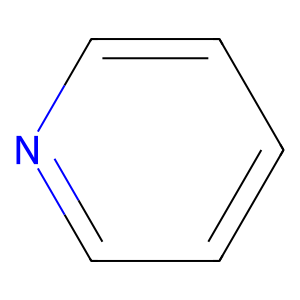

In [ ]:
# Draw the substructure in chemdraw, draw only the common structure you want to analyze, and save the file as a prefix.cdxml

# !change your file name here
common_structure_file = "pyrd.cdxml"

substructure = Chem.MolsFromCDXMLFile(common_structure_file)
# output to SMILES
temp_smiles = Chem.MolToSmiles(substructure[0])
# reparse the SMILES
substructure = Chem.MolFromSmiles(temp_smiles)

# print the molecule
Chem.Draw.MolToImage(substructure)

### Generate preliminary dataframe

In [ ]:
#generate a list of molecules using RDkit
all_compounds = Chem.SDMolSupplier('molecules.sdf', removeHs=False) 
#molecules.sdf is generated with the instructions above
#it is a single sdf that contains the structures/atom numbers etc. for every molecule you will analyze

#uses RDKit to search for the substructure in each compound you will analyze
atoms = []
for molecule in all_compounds:
    if molecule is not None:
        submatch = molecule.GetSubstructMatches(substructure) #find substructure
        matchlist = list([item for sublist in submatch for item in sublist]) #list of zero-indexed atom numbers
        match_idx = [x+1 for x in matchlist] #this line changes from 0-indexed to 1-indexed (for Gaussian)
        atoms.append(match_idx) #append 1-indexed list to atoms (a list of lists)
        
#this loop extracts log names from log_ids and splits them to the desired format
filenames = open("log_ids.txt", "r") #generate this with instruction above
#it is a text file that contains the file name for every molecule you will analyze
list_of_filenames = [(line.strip()).split() for line in filenames] #list of the file names (each of which includes all conformers)
list_of_files = []
for filename in list_of_filenames:
    file = filename[0].split(".")
    list_of_files.append(file[0])
filenames.close()

#put the atom numbers for the substructure for each log file into a dataframe
prelim_df = pd.DataFrame(atoms) 
index=list_of_files
prelim_df.insert(0,column='log_name',value=list_of_files)
display(prelim_df)

### Define column headers using GaussView

Using the preliminary dataframe displayed above, open one of your files and check the atom numbers. 

Assign labels to each column using the cell below. You will call these column headers when you select your properties. 

**User input required:**

In [ ]:
atom_labels = {'log_name': 'log_name',
                0: 'C4',
                1: 'C5', 
                2: 'N1',
                3: 'C1',
                4: 'C2',
                5: 'C3'}

### Generate labeled dataframe

**NOTE: it is very important you assign these correctly otherwise the properties you collect will be for the wrong atoms and not produce meaningful correlations.** 

We recommend checking the numbering/headers for at least two different compounds. 

Numbering for different conformers of the same compounds will likely be the same (but may not be for some symmetrical groups).

In [ ]:
#rename columns using the user input above
atom_map_df = prelim_df.rename(columns=atom_labels)
display(atom_map_df)

#you can use this to clean up the table if you have more atoms in your substructure than you want to collect descriptors for
#atom_map_df = atom_map_df.drop(columns= ['C4', 'C1']) 
#display(atom_map_df.head())

df = atom_map_df #df is what properties will be appended to, this creates a copy so that you have the original preserved 

### Save atom map to Excel (if desired)

In [ ]:
writer = pd.ExcelWriter('pyrd_atom_map.xlsx')
atom_map_df.to_excel(writer)
writer.close()

## Import a manually-generated atom mapping dataframe

If you need to manually generate the atom mapping dataframe, check out the atom_map_sample.xlsx to make sure you have the desired format. 

In [ ]:
atom_map_df = pd.read_excel('pyrd_atom_map.xlsx','Sheet1',index_col=0,header=0,engine='openpyxl')
display(atom_map_df.head())
df = atom_map_df #df is what properties will be appended to, this creates a copy so that you have the original preserved 

# Define Properties to Collect

## Available property functions and how to call them: 

In [ ]:
#this box has functions to choose from
df = atom_map_df

#---------------GoodVibes Engergies---------------
#uses the GoodVibes 2021 Branch (Jupyter Notebook Compatible)
#calculates the quasi harmonic corrected G(T) and single point corrected G(T) as well as other thermodynamic properties
#inputs: dataframe, temperature
#df = gp.get_goodvibes_e(df, 298.15)

#---------------Frontier Orbitals-----------------
#E(HOMO), E(LUMO), mu(chemical potential or negative of molecular electronegativity), eta(hardness/softness), omega(electrophilicity index)
#df = gp.get_frontierorbs(df)

#---------------Polarizability--------------------
#Exact polarizability
#df = gp.get_polarizability(df)

#---------------Dipole----------------------------
#Total dipole moment magnitude in Debye
#df = gp.get_dipole(df)

#---------------Volume----------------------------
#Molar volume
#requires the Gaussian keyword = "volume" in the .com file
#df = gp.get_volume(df)

#---------------SASA------------------------------
#Uses morfeus to calculat sovlent accessible surface area and the volume under the SASA
#df = gp.get_SASA(df)

#---------------NBO-------------------------------
#natural charge from NBO
#requires the Gaussian keyword = "pop=nbo7" in the .com file
#nbo_list = ["C1", "N", "H1", "H2"]
#df = gp.get_nbo(df, nbo_list) 

#---------------NMR-------------------------------
#isotropic NMR shift
#requires the Gaussian keyword = "nmr=giao" in the .com file
#nmr_list = ["C1", "H1", "N1"]
#df = gp.get_nmr(df, nmr_list) 

#---------------Distance--------------------------
#distance between 2 atoms
#dist_list_of_lists = [["N", "C1"], ["N", "H1"]]
#df = gp.get_distance(df, dist_list_of_lists) 

#---------------Angle-----------------------------
#angle between 3 atoms
#angle_list_of_lists = [["H1", "N", "C1"], ["N", "C1", "C2"]]
#df = gp.get_angles(df, angle_list_of_lists) 

#---------------Dihedral--------------------------
#dihedral angle between 4 atoms
#dihedral_list_of_lists = [["O2", "C1", "O3", "H5"], ["C4", "C1", "O3", "H5"]]
#df = gp.get_dihedral(df, dihedral_list_of_lists) 

#---------------Vbur Scan-------------------------
#uses morfeus to calculate the buried volume at a series of radii (including hydrogens)
#inputs: dataframe, list of atoms, start_radius, end_radius, and step_size
#if you only want a single radius, put the same value for start_radius and end_radius (keep step_size > 0)
#vbur_list = ["N", "H1"]
#df = gp.get_vbur_scan(df, vbur_list, 2, 4, 0.5)
    
#---------------Sterimol morfeus------------------
#uses morfeus to calculate Sterimol L, B1, and B5 values
#NOTE: this is much faster than the corresponding DBSTEP function (recommendation: use as default/if you don't need Sterimol2Vec)
#sterimol_list_of_lists = [["N1", "H1"], ["N1", "C1"]]
#df = gp.get_sterimol_morfeus(df, sterimol_list_of_lists) 

#---------------Buried Sterimol-------------------
#uses morfeus to calculate Sterimol L, B1, and B5 values within a given sphere of radius r_buried
#atoms outside the sphere + 0.5 vdW radius are deleted and the Sterimol vectors are calculated
#for more information: https://kjelljorner.github.io/morfeus/sterimol.html
#inputs: dataframe, list of atom pairs, r_buried
#sterimol_list_of_lists = [["N", "C1"]]
#df = gp.get_buried_sterimol(df, sterimol_list_of_lists, 5.5) 

#---------------Sterimol DBSTEP-------------------
#uses DBSTEP to calculate Sterimol L, B1, and B5 values
#default grid point spacing (0.05 Angstrom) is used (can use custom spacing or vdw radii in the get_properties_functions script)
#more info here: https://github.com/patonlab/DBSTEP
#NOTE: this takes longer than the morfeus function (recommendation: only use this if you need Sterimol2Vec)
#sterimol_list_of_lists = [["N", "H1"]]
#df = gp.get_sterimol_dbstep(df, sterimol_list_of_lists) 

#---------------Sterimol2Vec----------------------
#uses DBSTEP to calculate Sterimol Bmin and Bmax values at intervals from 0 to end_radius, with a given step_size 
#default grid point spacing (0.05 Angstrom) is used (can use custom spacing or vdw radii in the get_properties_functions script)
#more info here: https://github.com/patonlab/DBSTEP
#inputs: dataframe, list of atom pairs, end_radius, and step_size
#sterimol2vec_list_of_lists = [["C1", "C4"]]
#df = gp.get_sterimol2vec(df, sterimol2vec_list_of_lists, 1, 1.0) 

#---------------Pyramidalization------------------
#uses morfeus to calculate pyramidalization based on the 3 atoms in closest proximity to the defined atom
#collects values based on two definitions of pyramidalization
#details on these values can be found here: https://kjelljorner.github.io/morfeus/pyramidalization.html
#pyr_list = ["C1", "C4"]
#df = gp.get_pyramidalization(df, pyr_list)

#---------------Plane Angle-----------------------
#plane angle between 2 planes (each defined by 3 atoms)
#planeangle_list_of_lists = [["O2", "C1", "O3", "H5", "C1", "C4"], ["O2", "C1", "O3", "H5", "C1", "C4"]]
#df = gp.get_planeangle(df, planeangle_list_of_lists) 

#--------------LP energy - custom from first cell---------------
#lp_list = ["N1"]
#df = get_one_lp_energy(df, lp_list) 

pd.options.display.max_columns = None
display(df)

In [ ]:
#this box has functions to choose from
df = atom_map_df

#---------------GoodVibes Engergies---------------
#uses the GoodVibes 2021 Branch (Jupyter Notebook Compatible)
#calculates the quasi harmonic corrected G(T) and single point corrected G(T) as well as other thermodynamic properties
#inputs: dataframe, temperature
# df = gp.get_goodvibes_e(df, 298.15)

#---------------Frontier Orbitals-----------------
#E(HOMO), E(LUMO), mu(chemical potential or negative of molecular electronegativity), eta(hardness/softness), omega(electrophilicity index)
df = gp.get_frontierorbs(df)

#---------------Polarizability--------------------
#Exact polarizability
df = gp.get_polarizability(df)

#---------------Dipole----------------------------
#Total dipole moment magnitude in Debye
df = gp.get_dipole(df)

#---------------Volume----------------------------
#Molar volume
#requires the Gaussian keyword = "volume" in the .com file
df = gp.get_volume(df)

#---------------SASA------------------------------
#Uses morfeus to calculat sovlent accessible surface area and the volume under the SASA
df = gp.get_SASA(df)

#---------------NBO-------------------------------
#natural charge from NBO
#requires the Gaussian keyword = "pop=nbo7" in the .com file
nbo_list = ["C1", "C2", "C3", "C4", "C5", "N1"]
df = gp.get_nbo(df, nbo_list)

#---------------NMR-------------------------------
#isotropic NMR shift
#requires the Gaussian keyword = "nmr=giao" in the .com file
nmr_list = ["C1", "C2", "C3", "C4", "C5", "N1"]
df = gp.get_nmr(df, nmr_list) 

#---------------Distance--------------------------
#distance between 2 atoms
dist_list_of_lists = [["N", "C1"], ["N", "C5"]]
df = gp.get_distance(df, dist_list_of_lists) 

#---------------Angle-----------------------------
#angle between 3 atoms
#angle_list_of_lists = [["H1", "N", "C1"], ["N", "C1", "C2"]]
#df = gp.get_angles(df, angle_list_of_lists) 

#---------------Dihedral--------------------------
#dihedral angle between 4 atoms
#dihedral_list_of_lists = [["O2", "C1", "O3", "H5"], ["C4", "C1", "O3", "H5"]]
#df = gp.get_dihedral(df, dihedral_list_of_lists) 

#---------------Vbur Scan-------------------------
#uses morfeus to calculate the buried volume at a series of radii (including hydrogens)
#inputs: dataframe, list of atoms, start_radius, end_radius, and step_size
#if you only want a single radius, put the same value for start_radius and end_radius (keep step_size > 0)
vbur_list = ["C1", "C2", "C3", "C4", "C5", "N1"]
df = gp.get_vbur_scan(df, vbur_list, 2, 4, 0.5)
    
#---------------Sterimol morfeus------------------
#uses morfeus to calculate Sterimol L, B1, and B5 values
#NOTE: this is much faster than the corresponding DBSTEP function (recommendation: use as default/if you don't need Sterimol2Vec)
sterimol_list_of_lists = [["N1", "C1"], ["N1", "C5"]]
df = gp.get_sterimol_morfeus(df, sterimol_list_of_lists) 

#---------------Buried Sterimol-------------------
#uses morfeus to calculate Sterimol L, B1, and B5 values within a given sphere of radius r_buried
#atoms outside the sphere + 0.5 vdW radius are deleted and the Sterimol vectors are calculated
#for more information: https://kjelljorner.github.io/morfeus/sterimol.html
#inputs: dataframe, list of atom pairs, r_buried
sterimol_list_of_lists = [["N1", "C1"], ["N1", "C5"]]
df = gp.get_buried_sterimol(df, sterimol_list_of_lists, 5.5) 

#---------------Sterimol DBSTEP-------------------
#uses DBSTEP to calculate Sterimol L, B1, and B5 values
#default grid point spacing (0.05 Angstrom) is used (can use custom spacing or vdw radii in the get_properties_functions script)
#more info here: https://github.com/patonlab/DBSTEP
#NOTE: this takes longer than the morfeus function (recommendation: only use this if you need Sterimol2Vec)
#sterimol_list_of_lists = [["N", "H1"]]
#df = gp.get_sterimol_dbstep(df, sterimol_list_of_lists) 

#---------------Sterimol2Vec----------------------
#uses DBSTEP to calculate Sterimol Bmin and Bmax values at intervals from 0 to end_radius, with a given step_size 
#default grid point spacing (0.05 Angstrom) is used (can use custom spacing or vdw radii in the get_properties_functions script)
#more info here: https://github.com/patonlab/DBSTEP
#inputs: dataframe, list of atom pairs, end_radius, and step_size
#sterimol2vec_list_of_lists = [["C1", "C4"]]
#df = gp.get_sterimol2vec(df, sterimol2vec_list_of_lists, 1, 1.0) 

#---------------Pyramidalization------------------
#uses morfeus to calculate pyramidalization based on the 3 atoms in closest proximity to the defined atom
#collects values based on two definitions of pyramidalization
#details on these values can be found here: https://kjelljorner.github.io/morfeus/pyramidalization.html
pyr_list = ["C1", "C2", "C3", "C4", "C5", "N1"]
df = gp.get_pyramidalization(df, pyr_list)

#---------------Plane Angle-----------------------
#plane angle between 2 planes (each defined by 3 atoms)
#planeangle_list_of_lists = [["O2", "C1", "O3", "H5", "C1", "C4"], ["O2", "C1", "O3", "H5", "C1", "C4"]]
#df = gp.get_planeangle(df, planeangle_list_of_lists) 

#--------------LP energy - custom from first cell---------------
lp_list = ["N1"]
df = get_one_lp_energy(df, lp_list) 

pd.options.display.max_columns = None
display(df)

## Copy and modify available property functions above to customize

We recommend copying the entire cell above. You will need to change the atom number lists to match your desired column headers and delete (or comment out) any properites you don't want to collect.

In [ ]:
#---------------GoodVibes Engergies---------------
#uses the GoodVibes 2021 Branch (Jupyter Notebook Compatible)
#calculates the quasi harmonic corrected G(T) and single point corrected G(T) as well as other thermodynamic properties
#inputs: dataframe, temperature
df = gp.get_goodvibes_e(df, 298.15)

#---------------Frontier Orbitals-----------------
#E(HOMO), E(LUMO), mu(chemical potential or negative of molecular electronegativity), eta(hardness/softness), omega(electrophilicity index)
df = gp.get_frontierorbs(df)

#---------------Sterimol DBSTEP-------------------
#uses DBSTEP to calculate Sterimol L, B1, and B5 values
#default grid point spacing (0.05 Angstrom) is used (can use custom spacing or vdw radii in the get_properties_functions script)
#more info here: https://github.com/patonlab/DBSTEP
#NOTE: this takes longer than the morfeus function (recommendation: only use this if you need Sterimol2Vec)
sterimol_list_of_lists = [["N1", "H3"]]
df = gp.get_sterimol_dbstep(df, sterimol_list_of_lists) 

#--------------LP energy - custom from first cell---------------
lp_list = ["N1"]
df = get_one_lp_energy(df, lp_list) 


## Other available property functions that are less common

In [ ]:
df = atom_map_df
#---------------Time----------------------------------
#returns the total CPU time and total Wall time (not per subjob) because we are pioneers
#if used in summary df, will give the average (not Boltzmann average) in the Boltzmann average column
df = gp.get_time(df)

#---------------ChelpG----------------------------
#ChelpG ESP charge 
#requires the Gaussian keyword = "pop=chelpg" in the .com file
a_list = ['C1']
df = gp.get_chelpg(df, a_list) 

#---------------Hirshfeld-------------------------
#Hirshfeld charge, CM5 charge, Hirshfeld atom dipole
#requires the Gaussian keyword = "pop=hirshfeld" in the .com file
a_list = ['C1']
df = gp.get_hirshfeld(df, a_list) 

#---------------IR--------------------------------
#CAUTION: CANNOT ACCURATELY IDENTIFY ATOM STRETCHES IN MOST CASES (strugges if there is more than one stretch in the defined range)
#IR frequencies and intensities in a specific range (for specific atoms)
#requires the Gaussian keyword = "freq=noraman" in the .com file
#inputs: dataframe, atom1, atom2, frequency_min, frequency_max, intensity_min, intensity_max, threshold
#if you want to collect multiple IR frequencies, you will need to copy/paste this function for each stretch
#we recommend a threshold of 0.0 (may have to adjust)
df = gp.get_IR(df, "C1", "O2", 1700, 1900, 100, 800, 0.0)

display(df)

## Save collected properties to Excel

Helpful to save here in case the Notebook crashes or if you want to add more properties before post-processsing. Can be read in at 5.1.1.

In [ ]:
writer = pd.ExcelWriter('properties.xlsx')
df.to_excel(writer)
writer.save()

# Post-processing

## User input for data processing

In [ ]:
#for numerically named compounds, prefix is any text common to all BEFORE the number and suffix is common to all AFTER the number
#this is a template for our files that are all named "AcXXX_clust-X.log" or "AcXXX_conf-X.log"
prefix = "an" 
suffix = "_"

#columns that provide atom mapping information are dropped
atom_columns_to_drop = ["H3", "N1", "H4", "C2"]

#title of the column for the energy you want to use for boltzmann averaging and lowest E conformer determination
energy_col_header = "G(T)_spc(Hartree)"

### Option to import an Excel sheet if you're using properties or energies collected outside of this notebook

If you would like to use post-processing functionality (i.e. Boltzmann averaging, lowest E conformers, etc.) you can read in a dataframe with properties (e.g. QikProp properties) or energies (e.g. if you don't/can't run linked jobs) collected outside of this notebook. 

Check out the dataframe_sample.xlsx to make sure you have the desired format. 

In [ ]:
df = pd.read_excel('manual_properties_sample.xlsx','Sheet1',index_col=0,header=0,engine='openpyxl')
display(df.head())

## Generating a list of compounds that have conformational ensembles

**ONLY RUN THE AUTOMATED OR THE MANUAL CELL, NOT BOTH**

**AUTOMATED:** if your compounds are named consistenly, this section generates your compound list based on the similar naming structure

In [ ]:
#this is a template for our files that are all named "AcXXX_clust-X.log"

compound_list = []
    
for index, row in df.iterrows():
    log_file = row['log_name'] #read file name from df
    prefix_and_compound = log_file.split(str(suffix)) #splits to get "AcXXX" (entry O) (and we don't use the "clust-X" (entry 1))
    compound = prefix_and_compound[0].split(str(prefix)) #splits again to get "XXX" (entry 1) (and we don't use the empty string "" (entry 0))
    compound_list.append(compound[1])

compound_list = list(set(compound_list)) #removes duplicate stuctures that result from having conformers of each
compound_list.sort() #reorders numerically (not sure if it reorders alphabetically)
print(compound_list)

#this should generate a list that looks like this: ['24', '27', '34', '48']

**MANUAL:** if your comment naming scheme is not consistent or you have trouble with the template above, you can manually define your compound list

In [ ]:
compound_list = [24, 27, 34, 48]

## Post-processing to get properties for each compound

In [ ]:
all_df_master = pd.DataFrame(columns=[])
properties_df_master = pd.DataFrame(columns=[])

for compound in compound_list: 
    #defines the common start to all files using the input above 
    substring = str(prefix) + str(compound) + str(suffix)
    
    #makes a data frame for one compound at a time for post-processing
    valuesdf = df[df["log_name"].str.startswith(substring)]
    valuesdf = valuesdf.drop(columns = atom_columns_to_drop)
    valuesdf = valuesdf.reset_index(drop = True)  #you must re-index otherwise the 2nd, 3rd, etc. compounds fail
   
    #define columns that won't be included in summary properties or are treated differently because they don't make sense to Boltzmann average
    non_boltz_columns = ["G(Hartree)","∆G(Hartree)","∆G(kcal/mol)", "e^(-∆G/RT)","Mole Fraction"] #don't boltzman average columns containing these strings in the column label
    reg_avg_columns = ['CPU_time_total(hours)', 'Wall_time_total(hours)'] #don't boltzmann average these either, we average them in case that is helpful
    gv_extra_columns = ['E_spc (Hartree)', 'H_spc(Hartree)', 'T', 'T*S', 'T*qh_S', 'ZPE(Hartree)', 'qh_G(T)_spc(Hartree)', "G(T)_spc(Hartree)"]
    gv_extra_columns.remove(str(energy_col_header))
    
    #calculate the summary properties based on all conformers (Boltzmann Average, Minimum, Maximum, Boltzmann Weighted Std)
    valuesdf["∆G(Hartree)"] = valuesdf[energy_col_header] - valuesdf[energy_col_header].min()
    valuesdf["∆G(kcal/mol)"] = valuesdf["∆G(Hartree)"] * 627.5
    valuesdf["e^(-∆G/RT)"] = np.exp((valuesdf["∆G(kcal/mol)"] * -1000) / (1.987204 * 298.15)) #R is in cal/(K*mol)
    valuesdf["Mole Fraction"] = valuesdf["e^(-∆G/RT)"] / valuesdf["e^(-∆G/RT)"].sum()
    values_boltz_row = []
    values_min_row = []
    values_max_row = []
    values_boltz_stdev_row =[]
    values_range_row = []
    values_exclude_columns = []
    
    for column in valuesdf:
        if "log_name" in column:
            values_boltz_row.append("Boltzmann Averages")
            values_min_row.append("Ensemble Minimum")
            values_max_row.append("Ensemble Maximum")
            values_boltz_stdev_row.append("Boltzmann Standard Deviation")
            values_range_row.append("Ensemble Range")
            values_exclude_columns.append(column) #used later to build final dataframe
        elif any(phrase in column for phrase in non_boltz_columns) or any(phrase in column for phrase in gv_extra_columns):
            values_boltz_row.append("")
            values_min_row.append("")
            values_max_row.append("")
            values_boltz_stdev_row.append("")
            values_range_row.append("")
        elif any(phrase in column for phrase in reg_avg_columns):
            values_boltz_row.append(valuesdf[column].mean()) #intended to print the average CPU/wall time in the boltz column
            values_min_row.append("")
            values_max_row.append("")
            values_boltz_stdev_row.append("")
            values_range_row.append("")
        else:
            valuesdf[column] = pd.to_numeric(valuesdf[column]) #to hopefully solve the error that sometimes occurs where the float(Mole Fraction) cannot be mulitplied by the string(property)
            values_boltz_row.append((valuesdf[column] * valuesdf["Mole Fraction"]).sum())
            values_min_row.append(valuesdf[column].min())
            values_max_row.append(valuesdf[column].max())
            values_range_row.append(valuesdf[column].max() - valuesdf[column].min())

            
            # this section generates the weighted std deviation (weighted by mole fraction) 
            # formula: https://www.statology.org/weighted-standard-deviation-excel/
    
            boltz = (valuesdf[column] * valuesdf["Mole Fraction"]).sum() #number
            delta_values_sq = []
    
            #makes a list of the "deviation" for each conformer           
            for index, row in valuesdf.iterrows(): 
                value = row[column]
                delta_value_sq = (value - boltz)**2
                delta_values_sq.append(delta_value_sq)
            
            #w is list of weights (i.e. mole fractions)
            w = list(valuesdf["Mole Fraction"])
            wstdev = np.sqrt( (np.average(delta_values_sq, weights=w)) / (((len(w)-1)/len(w))*np.sum(w)) )
            if len(w) == 1: #if there is only one conformer in the ensemble, set the weighted standard deviation to 0 
                wstdev = 0
            #np.average(delta_values_sq, weights=w) generates sum of each (delta_value_sq * mole fraction)
            
            values_boltz_stdev_row.append(wstdev)
            
            
    valuesdf.loc[len(valuesdf)] = values_boltz_row
    valuesdf.loc[len(valuesdf)] = values_boltz_stdev_row
    valuesdf.loc[len(valuesdf)] = values_min_row
    valuesdf.loc[len(valuesdf)] = values_max_row
    valuesdf.loc[len(valuesdf)] = values_range_row

    #final output format is built here:
    explicit_order_front_columns = ["log_name", energy_col_header,"∆G(Hartree)","∆G(kcal/mol)","e^(-∆G/RT)","Mole Fraction"]
    
    #reorders the dataframe using front columns defined above
    valuesdf = valuesdf[explicit_order_front_columns + [col for col in valuesdf.columns if col not in explicit_order_front_columns and col not in values_exclude_columns]]
    
    #determine the index of the lowest energy conformer
    low_e_index = valuesdf[valuesdf["∆G(Hartree)"] == 0].index.tolist()
    
    #copy the row to a new_row with the name of the log changed to Lowest E Conformer
    new_row = valuesdf.loc[low_e_index[0]]
    new_row['log_name'] = "Lowest E Conformer"   
    valuesdf =  valuesdf.append(new_row, ignore_index=True)

#------------------------------EDIT THIS SECTION IF YOU WANT A SPECIFIC CONFORMER----------------------------------  
    #if you want all properties for a conformer with a particular property (i.e. all properties for the Vbur_min conformer)
    #this template can be adjusted for min/max/etc. 
    
    #find the index for the min or max column:
    #ensemble_min_index = valuesdf[valuesdf["log_name"] == "Ensemble Minimum"].index.tolist()
    
    #find the min or max value of the property (based on index above)
    #saves the value in a list (min_value) with one entry (this is why we call min_value[0])
    #min_value = valuesdf.loc[ensemble_min_index, "%Vbur_C4_3.0Å"].tolist()   
    #vbur_min_index = valuesdf[valuesdf["%Vbur_C4_3.0Å"] == min_value[0]].index.tolist()
    
    #copy the row to a new_row with the name of the log changed to Property_min_conformer
    #new_row = valuesdf.loc[vbur_min_index[0]]
    #new_row['log_name'] = "%Vbur_C4_3.0Å_min_Conformer"   
    #valuesdf =  valuesdf.append(new_row, ignore_index=True)
#--------------------------------------------------------------------------------------------------------------------    
    
    #appends the frame to the master output
    all_df_master = pd.concat([all_df_master, valuesdf])
    
    #drop all the individual conformers
    dropindex = valuesdf[valuesdf["log_name"].str.startswith(substring)].index
    valuesdf = valuesdf.drop(dropindex)
    valuesdf = valuesdf.reset_index(drop = True)
    
    #display(valuesdf)   
    
    #drop the columns created to determine the mole fraction and some that 
    valuesdf = valuesdf.drop(columns = explicit_order_front_columns)
    try:
        valuesdf = valuesdf.drop(columns = gv_extra_columns)
    except:
        pass
    try:
        valuesdf = valuesdf.drop(columns = reg_avg_columns)
    except:
        pass
        
#---------------------THIS MAY NEED TO CHANGE DEPENDING ON HOW YOU LABEL YOUR COMPOUNDS------------------------------  
    compound_name = prefix + str(compound) 
#--------------------------------------------------------------------------------------------------------------------      

    properties_df = pd.DataFrame({'Compound_Name': [compound_name]})
    
    #builds a dataframe (for each compound) by adding summary properties as new columns
    for (columnName, columnData) in valuesdf.iteritems():
        #the indexes need to match the values dataframe - display it to double check if you need to make changes 
        #(uncomment the display(valuesdf) in row 124 of this cell)
        properties_df[str(columnName) + "_Boltz"] = [columnData.values[0]]
        properties_df[str(columnName) + "_Boltz_stdev"] = [columnData.values[1]]
        properties_df[str(columnName) + "_min"] = [columnData.values[2]]
        properties_df[str(columnName) + "_max"] = [columnData.values[3]]
       #properties_df[str(columnName) + "_range"] = [columnData.values[4]]
        properties_df[str(columnName) + "_low_E"] = [columnData.values[5]]
        
        #if you're collecting properties for a specific conformer, add these here (note the index)
        #example:
        #properties_df[str(columnName) + "_V_bur_min"] = [columnData.values[6]]
        
        #if you only want a table with Boltz, you can comment out the other summary properties to generate a Boltz spreadsheet
        #of if you don't want to collect range, etc.
    #concatenates the individual acid properties df into the master properties df
    properties_df_master = pd.concat([properties_df_master, properties_df], axis = 0)

all_df_master = all_df_master.reset_index(drop = True)
properties_df_master = properties_df_master.reset_index(drop = True)


### Peek at your new dataframes

In [ ]:
display(properties_df_master.head())
display(all_df_master)

### Save to Microsoft Excelᵀᴹ 

In [ ]:
all_df_master.to_excel('an01_an03.xlsx', index = False)
properties_df_master.to_excel('Summary_Properties_for_An01_to_An03.xlsx', index = False)